# **Waze Project**

The purpose of this model is to find factors that drive user churn.
The goal of this model is to predict whether or not a Waze user is retained or churned.
<br/>
**Part 1:** Ethical considerations
* Consider the ethical implications of the request

* Should the objective of the model be adjusted?

**Part 2:** Feature engineering

* Perform feature selection, extraction, and transformation to prepare the data for modeling

**Part 3:** Modeling
* Build the models, evaluate them, and advise on next steps

### **Imports and data loading**


In [3]:
# Import packages for data
import numpy as np
import pandas as pd

# For plotting
import matplotlib.pyplot as plt

# Show all columns
pd.set_option('display.max_columns', None)

# For modeling
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Plot feature importance
from xgboost import plot_importance

# Save models
import pickle



In [4]:
# Import dataset
df_dataset=pd.read_csv('waze_dataset.csv')

In [5]:
df_dataset.head()

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android


### **Feature engineering**

In [6]:
df= df_dataset.copy()
df.info()

#We create a feature representing the mean number of kilometers driven on each driving day in the last month for each user and we get the statistics from this feature

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       14999 non-null  int64  
 1   label                    14299 non-null  object 
 2   sessions                 14999 non-null  int64  
 3   drives                   14999 non-null  int64  
 4   total_sessions           14999 non-null  float64
 5   n_days_after_onboarding  14999 non-null  int64  
 6   total_navigations_fav1   14999 non-null  int64  
 7   total_navigations_fav2   14999 non-null  int64  
 8   driven_km_drives         14999 non-null  float64
 9   duration_minutes_drives  14999 non-null  float64
 10  activity_days            14999 non-null  int64  
 11  driving_days             14999 non-null  int64  
 12  device                   14999 non-null  object 
dtypes: float64(3), int64(8), object(2)
memory usage: 1.5+ MB


In [7]:
# `km_per_driving_day` feature
df['km_per_driving_day'] = df['driven_km_drives'] / df['driving_days']

# Statistics
df['km_per_driving_day'].describe()

C:\Users\carol\AppData\Roaming\Python\Python312\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


count    1.499900e+04
mean              inf
std               NaN
min      3.022063e+00
25%      1.672804e+02
50%      3.231459e+02
75%      7.579257e+02
max               inf
Name: km_per_driving_day, dtype: float64

In [8]:
#Converting infinite values to zero
df.loc[df['km_per_driving_day']==np.inf, 'km_per_driving_day'] = 0
df['km_per_driving_day'].describe()
#`percent_sessions_in_last_month` feature
df['percent_sessions_in_last_month'] = df['sessions'] / df['total_sessions']
# Statistics
df['percent_sessions_in_last_month'].describe()

count    14999.000000
mean         0.449255
std          0.286919
min          0.000000
25%          0.196221
50%          0.423097
75%          0.687216
max          1.530637
Name: percent_sessions_in_last_month, dtype: float64

In [9]:
# Add 'professional_driver' column
df['professional_driver'] = np.where((df['drives'] >= 60) & (df['driving_days'] >= 15), 1, 0)
# Add 'total_sessions_per_day' column
df['total_sessions_per_day'] = df['total_sessions'] / df['n_days_after_onboarding']
#Describe 
df['total_sessions_per_day'].describe()

# Add`km_per_hour` feature
df['km_per_hour'] = df['driven_km_drives'] / (df['duration_minutes_drives'] / 60)
df['km_per_hour'].describe()
# Add `km_per_drive` feature
df['km_per_drive'] = df['driven_km_drives'] / df['drives']
df['km_per_drive'].describe()

#Converting infinite values to zero
df.loc[df['km_per_drive']==np.inf, 'km_per_drive'] = 0
df['km_per_drive'].describe()

#`percent_of_sessions_to_favorite` feature
df['percent_of_drives_to_favorite'] = (
    df['total_navigations_fav1'] + df['total_navigations_fav2']) / df['total_sessions']
df['percent_of_drives_to_favorite'].describe()

C:\Users\carol\AppData\Roaming\Python\Python312\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


count    14999.000000
mean         1.665439
std          8.865666
min          0.000000
25%          0.203471
50%          0.649818
75%          1.638526
max        777.563629
Name: percent_of_drives_to_favorite, dtype: float64

### **Droping the  missing values**
Since previous EDA shows no evidence of a non-random cause for the 700 missing values in the `label` column, and these observations make up less than 5% of the data, use the `dropna()` method to remove the rows with missing data.

In [10]:
# Droping rows with missing values
df = df.dropna(subset=['label'])

### **Variable encoding**

In [11]:
#Dummies features
# We add `device2` variable
df['device2'] = np.where(df['device']=='Android', 0, 1)
df[['device', 'device2']].tail()

,device,device2
14994,iPhone,1
14995,Android,0
14996,iPhone,1
14997,iPhone,1
14998,iPhone,1


In [12]:
#Target encoding
# Add binary `label2` column
df['label2'] = np.where(df['label']=='churned', 1, 0)
df[['label', 'label2']].tail()

,label,label2
14994,retained,0
14995,retained,0
14996,retained,0
14997,churned,1
14998,retained,0


### **Feature selection**
Here we drop the ID column because this is a tree-based models and can handle multicollinearity but we still don't need the ID 

In [13]:
#Dropping ID
df = df.drop(['ID'], axis=1)

### **Evaluation metric**

Before modeling, choose an evaluation metric based on class balance and the model's use case.

In [14]:
#We examine first the class balance of 'label' col
df['label'].value_counts(normalize=True)

label
retained    0.822645
churned     0.177355
Name: proportion, dtype: float64

About 18% of users in this dataset churned. The dataset is unbalanced but not severely. You can model it without rebalancing the classes.
Model can have high accuracy on imblanced data and still fail to predict the minority class. 
We have to selec the model based on the recall score. 

### **Modeling workflow and model selection process**
The final dataset has 14,299 samples. 
This is on the lower side for robust model selection but it's still enough to proceed.
So first we have to split the data here we do (60/60/20)=(train/validation/test), then we fit, tune hyperparameters (on the training set)

### **Split the data**

In [26]:
#Drop 'label', 'label2', and 'device' columns from X
X = df.drop(columns=['label', 'label2', 'device'])

#Use 'label2' as y
y = df['label2']

#Split into train and test sets (80% train, 20% test)
X_tr, X_test, y_tr, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

#Split train set into train and validate sets (75% train, 25% validate)
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, stratify=y_tr, test_size=0.25, random_state=42)

for x in [X_train, X_val, X_test]:
    print(len(x))

8579
2860
2860


### Modeling**
We are using the GridSearchCV for tunning the random forest model


In [27]:
import time
# Create a Random Forest classifier
rf = RandomForestClassifier(random_state=42)

# Create a dictionary of hyperparameters to tune
cv_params = {
    'max_depth': [None],
    'max_features': [1.0],
    'max_samples': [1.0],
    'min_samples_leaf': [2],
    'min_samples_split': [2],
    'n_estimators': [300]
}

# Dictionary of scoring metrics to capture
scoring = {'accuracy': 'accuracy', 'precision': 'precision', 'recall': 'recall', 'f1': 'f1'}

# Instantiate the GridSearchCV object
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='recall')

# Measure the time taken to fit the model
start_time = time.time()
rf_cv.fit(X_train, y_train)
end_time = time.time()

# Display the time taken
print("Execution time: {:.2f} seconds".format(end_time - start_time))


Execution time: 113.92 seconds


In [28]:
# Checking best score
rf_cv.best_score_

0.12678201409034398

In [29]:
# Checking best hyperparameter combo
rf_cv.best_params_

{'max_depth': None,
 'max_features': 1.0,
 'max_samples': 1.0,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 300}

In [30]:
def make_results(model_name:str, model_object, metric:str):
    '''Arguments:
        model_name (string): what you want the model to be called in the output table
        model_object: a fit GridSearchCV object
        metric (string): precision, recall, f1, or accuracy

    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean 'metric' score across all validation folds.
    '''
 # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy',
                   }
 # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

# Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

# Extract accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

# Create table of results
    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy],
                          },
                         )

    return table

In [31]:
results = make_results('RF cv', rf_cv, 'recall')
results

,model,precision,recall,F1,accuracy
0,RF cv,0.457163,0.126782,0.198445,0.81851


The score is not thta good, but the recall is aroound ~0.09 = this model has 33% better recall and the same accuracy.

#### **XGBoost**
We try to improve our scores using an XGBoost model

In [38]:
#XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=42)

# Create a dictionary of hyperparameters to tune
cv_params = {
    'max_depth': [6, 12],
    'min_child_weight': [3, 5],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [300]
}

# Dictionary of scoring metrics to capture
scoring = {'accuracy': 'accuracy', 'precision': 'precision', 'recall': 'recall', 'f1': 'f1'}

# Instantiate the GridSearchCV object
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=4, refit='recall')

# Measure the time taken to fit the model
start_time = time.time()
xgb_cv.fit(X_train, y_train)
end_time = time.time()

# Display the time taken
print("Execution time: {:.2f} seconds".format(end_time - start_time))

Execution time: 22.47 seconds


In [39]:
# Examine best score
xgb_cv.best_score_


0.1708264263019754

In [40]:
# Examine best parameters
xgb_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 6,
 'min_child_weight': 5,
 'n_estimators': 300}

In [41]:
# 'make_results()' on the GridSearch object
xgb_cv_results = make_results('XGB cv', xgb_cv, 'recall')
results = pd.concat([results, xgb_cv_results], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.457163,0.126782,0.198445,0.818510
0,XGB cv,0.425932,0.170826,0.243736,0.811866


This model fits better than the random forest. Its recall score is nearly double that of the logistic regression and 50% better than the random forest, with similar accuracy and precision.

### **Model selection**
We use the best RF and XGBoost model, the one with the best result will be selected

In [42]:
#Random forest model to predict on validation data
rf_val_preds = rf_cv.best_estimator_.predict(X_val)

In [43]:
def get_test_scores(model_name:str, preds, y_test_data):
    '''
    Generate a table of test scores.

    In:
        model_name (string): Your choice: how the model will be named in the output table
        preds: numpy array of test predictions
        y_test_data: numpy array of y_test data

    Out:
        table: a pandas df of precision, recall, f1, and accuracy scores for your model
    '''
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy]
                          })

    return table

In [44]:
#Scores for RF model
rf_val_scores = get_test_scores('RF val', rf_val_preds, y_val)

results = pd.concat([results, rf_val_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.457163,0.126782,0.198445,0.818510
0,XGB cv,0.425932,0.170826,0.243736,0.811866
0,RF val,0.445255,0.120316,0.189441,0.817483


same process with XGboost

In [45]:
# XGBoost model to predict on validation data
xgb_val_preds = xgb_cv.best_estimator_.predict(X_val)

xgb_val_scores = get_test_scores('XGB val', xgb_val_preds, y_val)
results = pd.concat([results, xgb_val_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.457163,0.126782,0.198445,0.818510
0,XGB cv,0.425932,0.170826,0.243736,0.811866
0,RF val,0.445255,0.120316,0.189441,0.817483
0,XGB val,0.422680,0.161736,0.233951,0.812238


Like the random forest, the XGBoost model's validation scores were slightly lower, but it remains the clear winner.

### **Using the best model to predict on test data**


In [47]:
# XGBoost
xgb_test_preds = xgb_cv.best_estimator_.predict(X_test)

# Scores
xgb_test_scores = get_test_scores('XGB test', xgb_test_preds, y_test)

# Results
results = pd.concat([results, xgb_test_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.457163,0.126782,0.198445,0.818510
0,XGB cv,0.425932,0.170826,0.243736,0.811866
0,RF val,0.445255,0.120316,0.189441,0.817483
0,XGB val,0.422680,0.161736,0.233951,0.812238
0,XGB test,0.423963,0.181460,0.254144,0.811189


The recall matched the validation data, but precision dropped, causing all other scores to decline slightly. However, the performance is still within the acceptable range.

### **Confusion matrix**

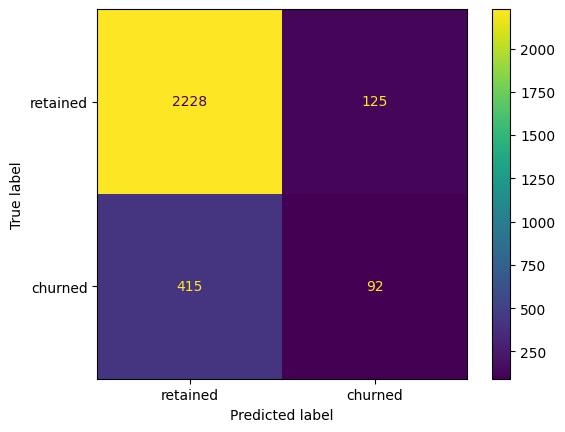

In [48]:
# Array of values: confusion matrix
cm = confusion_matrix(y_test, xgb_test_preds, labels=xgb_cv.classes_)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=['retained', 'churned'])
disp.plot();

### **Feature importance**

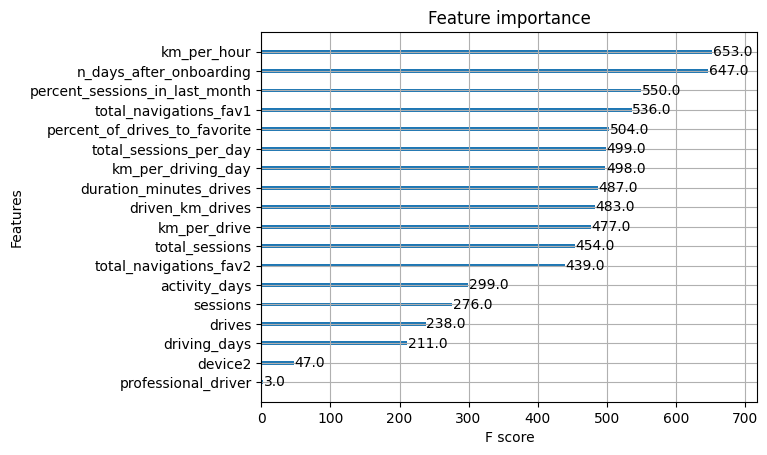

In [49]:
plot_importance(xgb_cv.best_estimator_);

### ** Conclusion**

Deciding to use this model for churn prediction depends on its purpose. It's not good enough for important business decisions due to its weak recall but can help in data exploration. 
Splitting data into training, validation, and test sets means less training data but better model selection. 
Logistic regression is easier to understand, while tree-based models like random forest and XGBoost predict better with less cleaning needed. 
To improve the model, create new features and test different variable combinations.
Additional useful features include individual drive details, detailed app usage data, and monthly counts of unique start and end locations.

#### **Identify an optimal decision threshold**

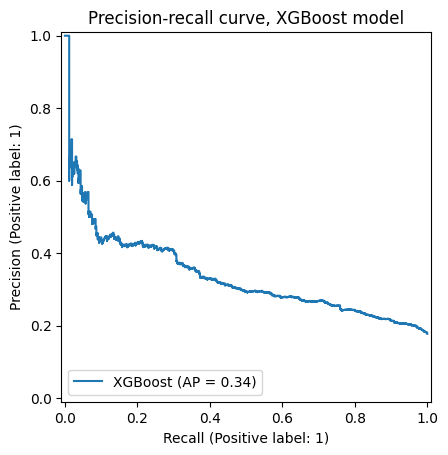

In [50]:
#Precision-recall curve
display = PrecisionRecallDisplay.from_estimator(
    xgb_cv.best_estimator_, X_test, y_test, name='XGBoost'
    )
plt.title('Precision-recall curve, XGBoost model');

In [51]:
#Predicted probabilities on the test data
predicted_probabilities = xgb_cv.best_estimator_.predict_proba(X_test)
predicted_probabilities

array([[0.94572806, 0.05427194],
       [0.57626796, 0.42373204],
       [0.98132175, 0.01867824],
       ...,
       [0.8135836 , 0.18641636],
       [0.9661311 , 0.03386891],
       [0.7386279 , 0.26137212]], dtype=float32)

In [52]:
#List of just the second column values
probs = [x[1] for x in predicted_probabilities]
# Array of new predictions that assigns a 1 to any value >= 0.4
new_preds = np.array([1 if x >= 0.4 else 0 for x in probs])
new_preds
#Evaluation metrics for when the threshold is 0.4
get_test_scores('XGB, threshold = 0.4', new_preds, y_test)

,model,precision,recall,F1,accuracy
0,"XGB, threshold = 0.4",0.414986,0.284024,0.337237,0.802098


In [53]:
results

,model,precision,recall,F1,accuracy
0,RF cv,0.457163,0.126782,0.198445,0.818510
0,XGB cv,0.425932,0.170826,0.243736,0.811866
0,RF val,0.445255,0.120316,0.189441,0.817483
0,XGB val,0.422680,0.161736,0.233951,0.812238
0,XGB test,0.423963,0.181460,0.254144,0.811189


Recall and F1 score increased significantly, while precision and accuracy decreased marginally.

In [54]:
def threshold_finder(y_test_data, probabilities, desired_recall):
    '''
    Find the decision threshold that yields a desired recall score.

    Inputs:
        y_test_data: True y values
        probabilities: Results from `predict_proba()`
        desired_recall: Target recall score

    Outputs:
        threshold: Decision threshold for desired recall
        recall: Actual recall score at that threshold
    '''
    probs = [x[1] for x in probabilities]  # Get probabilities for the positive class
    thresholds = np.arange(0, 1, 0.001)    # Test 1,000 thresholds

    scores = [(threshold, recall_score(y_test_data, [1 if x >= threshold else 0 for x in probs]))
              for threshold in thresholds]

    best_idx = np.argmin([abs(score[1] - desired_recall) for score in scores])
    threshold, recall = scores[best_idx]

    return threshold, recall


In [55]:
#Probabilities from best model
probabilities = xgb_cv.best_estimator_.predict_proba(X_test)

threshold_finder(y_test, probabilities, 0.5)

(0.194, 0.4990138067061144)

Setting a threshold of 0.194 will result in a recall of 0.499. Based on the precision-recall curve, a 0.5 recall score should have a precision of ~0.3.

In [59]:
# Creating an array of new predictions that assigns a 1 to any value >= 0.194
probs = [x[1] for x in probabilities]
new_preds = np.array([1 if x >= 0.194 else 0 for x in probs])

#Evaluation metrics for when the threshold is 0.124
get_test_scores('XGB, threshold = 0.194', new_preds, y_test)

,model,precision,recall,F1,accuracy
0,"XGB, threshold = 0.194",0.293163,0.499014,0.369343,0.697902
